# Looking at the historical US market returns

## Imports

In [146]:
import pandas as pd
import matplotlib.pyplot as plt

## Data

### Shiller's historical S&P 500 data

In [147]:
df = pd.read_excel('../data/shiller_sp500.xls', sheet_name='Data', header=None, skiprows=8)

#### Manually adjust columns names

There's some weird formatting due to a preamble above the first several columns and some unused columns.  I chose slightly shorter names here for convenience and drop the columns with no actual data.

In [148]:
dropped_columns = ["No Data 1", "No Data 2"]

columns = [
    "Date",
    "S&P",
    "Dividend",
    "Earnings",
    "CPI",
    "Date Fraction",
    "Long Interest Rate",
    "Real Price",
    "Real Dividend",
    "Real Total Return Price",
    "Real Earnings",
    "Real TR Scaled Earnings",
    "CAPE",
    dropped_columns[0],
    "TR CAPE",
    dropped_columns[1],
    "Excess CAPE Yield",
    "Monthly Bond Returns",
    "Monthly Real Bond Returns",
    "10 Year Real Stock Return",
    "10 Year Real Bond Return",
    "10 Year Excess Return"
]

df.columns = columns

# Sanity check
filled_dropped_rows = df[~df[dropped_columns[0]].isna() | ~df[dropped_columns[1]].isna()]
print("Was there any data in the dropped columns?", len(filled_dropped_rows) > 0)

# Drop the rows
df = df.drop(columns=dropped_columns)

Was there any data in the dropped columns? False


#### Drop trailing row that contains words

The last row has words for some entries, describing the methodology.  These will confuse plots/analyses, so they're dropped.

In [149]:
last_index = len(df) - 1
df = df.drop(last_index)

## Analysis

### Test plotting

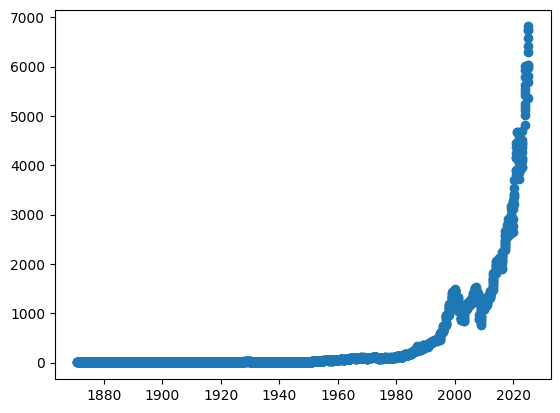

In [150]:
plt.scatter(x=df["Date"], y=df["S&P"])